# GAT Model Evaluation

In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from preprocessing.featurisation import get_atom_features, get_bond_features
from preprocessing.fetch_smiles import resolve_smiles_by_cas_interactive
from preprocessing.smiles_to_graph import batch_from_csv

In [2]:
graph_list = batch_from_csv('data/processed/input.csv')
molecules_df = pd.read_csv('data/processed/input.csv')

In [3]:
num_node_features = graph_list[0].num_node_features
num_edge_features = graph_list[0].num_edge_features
avg_degree = 2*(graph_list[0].num_edges) / graph_list[0].num_nodes
print(f"Number of node features: {num_node_features}")
print(f"Average degree of the graph: {avg_degree:.2f}") # From the avg. degree we can use at least 4 GCNConv layers
print(f"Number of edge features: {num_edge_features}")


Number of node features: 79
Average degree of the graph: 4.00
Number of edge features: 10


In [4]:
import torch
import random
import numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)


In [5]:
from torch_geometric.loader import DataLoader
batch = DataLoader(graph_list, batch_size=32, shuffle=True)

In [6]:
from torch.nn import MSELoss
from torch_geometric.loader import DataLoader

def train_gat_model(dataloader, model, lr=1e-3, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch).squeeze()
            target = batch.y.squeeze()

            assert out.shape == target.shape, f"{out.shape=} vs {target.shape=}"
            loss = loss_fn(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    
    return model

train_loader = DataLoader(graph_list, batch_size=32, shuffle=True)

In [7]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


def plot_predictions(model, loader):
    """
    Function to plot predictions vs actual values without scaling.
    """
    all_preds = [] 
    all_targets = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            preds = model(batch.x, batch.edge_index, batch.batch)
            # all_preds.append(preds.squeeze())
            # all_targets.append(batch.y.squeeze())
            all_preds.append(preds.view(-1))     # ensures [N]
            all_targets.append(batch.y.view(-1)) # ensures [N]

    all_preds = torch.cat(all_preds).cpu().numpy()
    all_targets = torch.cat(all_targets).cpu().numpy()

    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    plt.figure(figsize=(6, 6))
    plt.scatter(all_targets, all_preds, alpha=0.7)
    plt.plot([all_targets.min(), all_targets.max()], 
             [all_targets.min(), all_targets.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Predicted vs. Actual - GAT Model (Batched)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [8]:
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU, Dropout

class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_dim, heads=2, concat=False)
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)
        return self.ffnn(x)

model = GATModel(num_node_features, hidden_dim=64, out_dim=1)
print(model)

GATModel(
  (conv1): GATConv(79, 64, heads=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [9]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
import torch

def plot_predictions_plotly(dataloader, model, metadata_df=None):
    """
    Function to plot predictions vs actual values using Plotly with hover tooltips.
    
    metadata_df: Optional DataFrame with molecule metadata.
                 Should have at least as many rows as total predictions.
                 Example columns: MoleculeName, SMILES, CAS.
    """
    all_preds = []
    all_targets = []

    # Put model in eval mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    # Flatten
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")

    # Build DataFrame
    df = pd.DataFrame({
        "Actual": all_targets,
        "Predicted": all_preds
    })

    # Merge metadata if available
    if metadata_df is not None:
        metadata_df = metadata_df.reset_index(drop=True)
        df = pd.concat([df, metadata_df.iloc[:len(df)].reset_index(drop=True)], axis=1)

    # Make plot
    fig = px.scatter(
        df,
        x="Actual",
        y="Predicted",
        hover_data={
            "Inhibitor Name": True,
            "Inh Power": False, #':.2f',
            "CAS Number": False,
            "SMILES": False
        },
        title="Predicted vs Actual - GAT Model (Batched)",
        labels={"Actual": "Actual", "Predicted": "Predicted"},
        height=600,
        width=600
    )

    # Identity line y=x
    fig.add_shape(
        type="line",
        x0=df["Actual"].min(),
        y0=df["Actual"].min(),
        x1=df["Actual"].max(),
        y1=df["Actual"].max(),
        line=dict(color="red", dash="dash"),
    )

    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(showlegend=False)
    fig.show()


Epoch 1, Loss: 104.1881
Epoch 2, Loss: 110.7513
Epoch 3, Loss: 104.2509
Epoch 4, Loss: 150.4182
Epoch 5, Loss: 119.7620
Epoch 6, Loss: 107.6909
Epoch 7, Loss: 140.4540
Epoch 8, Loss: 114.3014
Epoch 9, Loss: 130.0388
Epoch 10, Loss: 126.2344
Epoch 11, Loss: 93.0031
Epoch 12, Loss: 117.3106
Epoch 13, Loss: 115.9312
Epoch 14, Loss: 91.1915
Epoch 15, Loss: 82.4450
Epoch 16, Loss: 126.9251
Epoch 17, Loss: 80.0647
Epoch 18, Loss: 84.0378
Epoch 19, Loss: 73.1302
Epoch 20, Loss: 91.2359
Epoch 21, Loss: 95.1299
Epoch 22, Loss: 91.4322
Epoch 23, Loss: 88.8093
Epoch 24, Loss: 75.2967
Epoch 25, Loss: 78.2496
Epoch 26, Loss: 91.2792
Epoch 27, Loss: 76.4550
Epoch 28, Loss: 80.6386
Epoch 29, Loss: 81.8692
Epoch 30, Loss: 91.3843
Epoch 31, Loss: 127.9024
Epoch 32, Loss: 78.1770
Epoch 33, Loss: 120.4886
Epoch 34, Loss: 97.9041
Epoch 35, Loss: 87.8768
Epoch 36, Loss: 92.1906
Epoch 37, Loss: 99.0979
Epoch 38, Loss: 95.4340
Epoch 39, Loss: 97.3522
Epoch 40, Loss: 77.0371
Epoch 41, Loss: 86.3703
Epoch 42, 

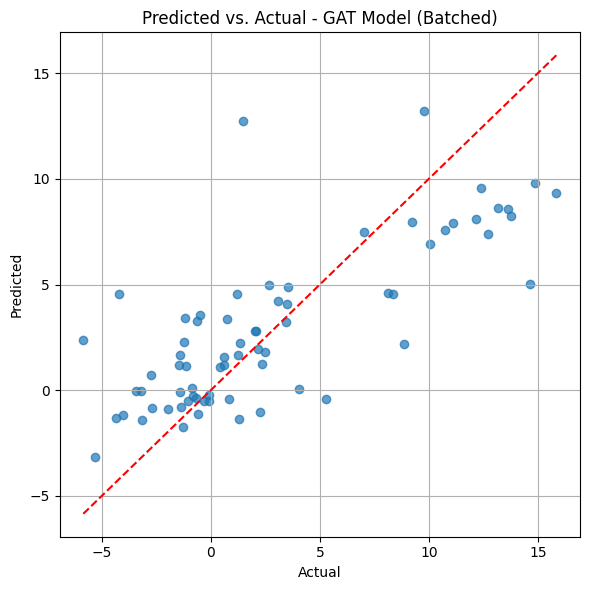

In [10]:
train_gat_model(train_loader, model, lr=1e-3, epochs=300)
plot_predictions(model, train_loader)

In [11]:
eval_loader = DataLoader(graph_list, batch_size=32, shuffle=False)
plot_predictions_plotly(eval_loader, model, metadata_df=molecules_df)

R² score: 0.586
RMSE: 3.644


## Predicting an arbitrary molecule

In [12]:
mol_to_predict = [graph_list[23]]
mol_to_predict[0].y

tensor([1.2800])

In [13]:
from torch_geometric.data import Batch

def predict_single_molecule(model, molecule_graph):
    model.eval()
    with torch.no_grad():
        batch = Batch.from_data_list([molecule_graph])  # wrap in a list

        prediction = model(
            batch.x, batch.edge_index, batch.batch
        )

        return round(prediction.item(), 4) 
predicted_value = predict_single_molecule(model, mol_to_predict[0])
predicted_value

-1.3572

## Effect of Training Parameters on model performance

Here, we will explore the effects of model training parameters (and small model changes) and how these affect model performance. Namely, we will explore the effects of:
* Number of layers used within the model
* Number of epochs used in training
* Learning rate
* Dropout rate


In [14]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import torch

def r2_rmse(dataloader, model):
    """
    Function to plot predictions vs actual values.
    This function however returns the R² score and RMSE.
    """
    all_preds = [] 
    all_targets = []

    # Put model in evaluation mode
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            preds = model(batch.x, batch.edge_index, batch.batch).squeeze()
            targets = batch.y.squeeze()

            # Handle possible shape mismatches
            if preds.dim() == 0:
                preds = preds.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Compute metrics
    r2 = r2_score(all_targets, all_preds)
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))

    print(f"R² score: {r2:.3f}")
    print(f"RMSE: {rmse:.3f}")
    
    return r2, rmse

### Number of Layers

In [15]:
metrics_layers = {}

#### 1 Layer

In [16]:
import torch
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU, Dropout

class GATModel1L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_dim, heads=2, concat=False)

        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
       
        x = global_mean_pool(x, batch)
        return self.ffnn(x)



In [39]:
model_1L = GATModel(num_node_features, hidden_dim=64, out_dim=1)
print(model_1L)

GATModel(
  (conv1): GATConv(79, 64, heads=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [38]:
metrics_layers['1Layer'] = r2_rmse(train_loader, model)
metrics_layers

R² score: 0.586
RMSE: 3.644


{'1Layer': (0.5859336853027344, np.float64(3.6437844904580774)),
 '2Layer': (0.8111395835876465, np.float64(2.4608669694754077)),
 '3Layer': (0.7450169920921326, np.float64(2.8593895083200063))}

#### 2 Layers

In [19]:
import torch
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU, Dropout

class GATModel2L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_dim, heads=2, concat=False)
        self.conv2 = GATConv(hidden_dim, hidden_dim, heads=2, concat=False)
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)
        return self.ffnn(x)



GATModel2L(
  (conv1): GATConv(79, 64, heads=2)
  (conv2): GATConv(64, 64, heads=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 1, Loss: 95.0749
Epoch 2, Loss: 107.5541
Epoch 3, Loss: 123.7191
Epoch 4, Loss: 115.7888
Epoch 5, Loss: 126.2616
Epoch 6, Loss: 111.8831
Epoch 7, Loss: 119.9268
Epoch 8, Loss: 125.8844
Epoch 9, Loss: 132.5528
Epoch 10, Loss: 113.2713
Epoch 11, Loss: 114.7264
Epoch 12, Loss: 87.9447
Epoch 13, Loss: 80.4693
Epoch 14, Loss: 82.1030
Epoch 15, Loss: 90.4723
Epoch 16, Loss: 96.8610
Epoch 17, Loss: 92.1286
Epoch 18, Loss: 102.1878
Epoch 19, Loss: 102.2799
Epoch 20, Loss: 78.5680
Epoch 21, Loss: 99.1074
Epoch 22, Loss: 87.8345
Epoch 23, Loss: 89.7252
Epoch 24, Loss: 108.6750
Epoch 25, Loss: 93.0497
Epoch 26, Loss: 74.7772
Epoch 27, Loss: 83.6641
Epoch 28, Loss: 85.6938
Epoch 29, Loss: 88.3150
Epoch 30, Loss

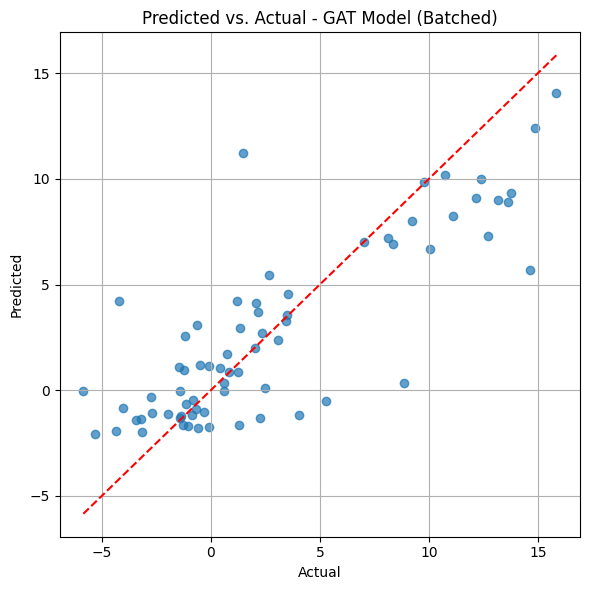

In [20]:
model_2L = GATModel2L(num_node_features, hidden_dim=64, out_dim=1)
print(model_2L)
train_gat_model(train_loader, model_2L, lr=1e-3, epochs=300)
plot_predictions(model_2L, train_loader)

In [21]:
train_gat_model(train_loader, model_2L, lr=1e-3, epochs=300)
metrics_layers['2Layer'] = r2_rmse(train_loader, model_2L)
metrics_layers

Epoch 1, Loss: 26.4981
Epoch 2, Loss: 23.5569
Epoch 3, Loss: 26.6835
Epoch 4, Loss: 40.6677
Epoch 5, Loss: 37.9415
Epoch 6, Loss: 28.3311
Epoch 7, Loss: 34.3377
Epoch 8, Loss: 28.6614
Epoch 9, Loss: 23.3019
Epoch 10, Loss: 26.2501
Epoch 11, Loss: 19.6769
Epoch 12, Loss: 30.8592
Epoch 13, Loss: 36.2037
Epoch 14, Loss: 21.6840
Epoch 15, Loss: 24.0421
Epoch 16, Loss: 48.8251
Epoch 17, Loss: 20.8078
Epoch 18, Loss: 41.7551
Epoch 19, Loss: 37.8172
Epoch 20, Loss: 27.4132
Epoch 21, Loss: 22.5161
Epoch 22, Loss: 29.3937
Epoch 23, Loss: 28.3630
Epoch 24, Loss: 20.8489
Epoch 25, Loss: 23.9740
Epoch 26, Loss: 23.8897
Epoch 27, Loss: 27.6451
Epoch 28, Loss: 32.1051
Epoch 29, Loss: 64.3711
Epoch 30, Loss: 25.0938
Epoch 31, Loss: 26.9320
Epoch 32, Loss: 32.2828
Epoch 33, Loss: 32.5344
Epoch 34, Loss: 33.4711
Epoch 35, Loss: 29.1637
Epoch 36, Loss: 20.4942
Epoch 37, Loss: 28.4720
Epoch 38, Loss: 21.9947
Epoch 39, Loss: 21.6047
Epoch 40, Loss: 22.3332
Epoch 41, Loss: 42.8587
Epoch 42, Loss: 22.2149
E

{'1Layer': (-0.2528170347213745, np.float64(6.338135588486342)),
 '2Layer': (0.8111395835876465, np.float64(2.4608669694754077))}

#### 3 Layers

In [22]:
import torch
from torch_geometric.nn import GATConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU, Dropout

class GATModel3L(torch.nn.Module):
    def __init__(self, in_channels, hidden_dim, out_dim=1, dropout_rate=0.2):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_dim, heads=2, concat=False)
        self.conv2 = GATConv(hidden_dim, hidden_dim, heads=2, concat=False)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=2, concat=False)
        self.ffnn = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)
        return self.ffnn(x)



In [23]:
model_3L = GATModel3L(num_node_features, hidden_dim=64, out_dim=1)
print(model_3L)

GATModel3L(
  (conv1): GATConv(79, 64, heads=2)
  (conv2): GATConv(64, 64, heads=2)
  (conv3): GATConv(64, 64, heads=2)
  (ffnn): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [24]:
train_gat_model(train_loader, model_3L, lr=1e-3, epochs=300)
metrics_layers['3Layer'] = r2_rmse(train_loader, model_3L)
metrics_layers

Epoch 1, Loss: 118.7569
Epoch 2, Loss: 144.0143
Epoch 3, Loss: 142.4317
Epoch 4, Loss: 151.8764
Epoch 5, Loss: 109.1806
Epoch 6, Loss: 140.2030
Epoch 7, Loss: 106.1213
Epoch 8, Loss: 131.5901
Epoch 9, Loss: 100.4021
Epoch 10, Loss: 117.6874
Epoch 11, Loss: 125.5974
Epoch 12, Loss: 94.4839
Epoch 13, Loss: 81.2773
Epoch 14, Loss: 81.7109
Epoch 15, Loss: 89.9720
Epoch 16, Loss: 91.7660
Epoch 17, Loss: 127.2609
Epoch 18, Loss: 97.9632
Epoch 19, Loss: 90.1484
Epoch 20, Loss: 91.6134
Epoch 21, Loss: 106.4429
Epoch 22, Loss: 109.3814
Epoch 23, Loss: 83.0185
Epoch 24, Loss: 127.3450
Epoch 25, Loss: 81.8060
Epoch 26, Loss: 124.2276
Epoch 27, Loss: 84.0204
Epoch 28, Loss: 96.5974
Epoch 29, Loss: 90.0028
Epoch 30, Loss: 80.8460
Epoch 31, Loss: 80.4136
Epoch 32, Loss: 98.6932
Epoch 33, Loss: 102.9693
Epoch 34, Loss: 90.4020
Epoch 35, Loss: 79.9067
Epoch 36, Loss: 82.1860
Epoch 37, Loss: 83.2859
Epoch 38, Loss: 96.9935
Epoch 39, Loss: 83.3115
Epoch 40, Loss: 64.8473
Epoch 41, Loss: 74.9466
Epoch 42

{'1Layer': (-0.2528170347213745, np.float64(6.338135588486342)),
 '2Layer': (0.8111395835876465, np.float64(2.4608669694754077)),
 '3Layer': (0.7450169920921326, np.float64(2.8593895083200063))}

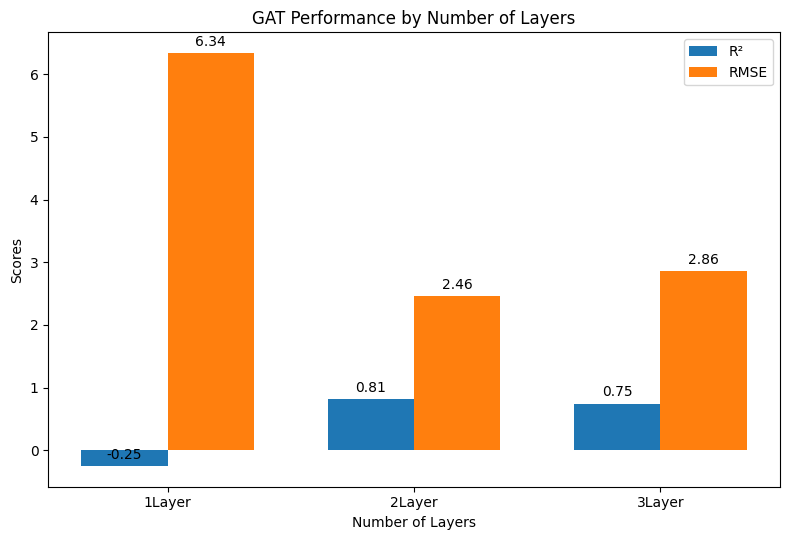

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_layers.keys())
r2_scores = [v[0] for v in metrics_layers.values()]
rmse_scores = [v[1] for v in metrics_layers.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Scores')
ax.set_title('GAT Performance by Number of Layers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Number of Epochs

In [26]:
train_epochs = [100, 200, 300, 400, 500]
metrics_epoch = {}
for epoch in train_epochs:
    gat_model = GATModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gat_model(train_loader, gat_model, lr=1e-3, epochs=epoch)
    metrics_epoch[epoch] = r2_rmse(train_loader, gat_model)
metrics_epoch

Epoch 1, Loss: 94.9733
Epoch 2, Loss: 135.2972
Epoch 3, Loss: 177.2491
Epoch 4, Loss: 128.5960
Epoch 5, Loss: 124.0507
Epoch 6, Loss: 112.6702
Epoch 7, Loss: 85.7462
Epoch 8, Loss: 91.0670
Epoch 9, Loss: 108.8096
Epoch 10, Loss: 127.6109
Epoch 11, Loss: 109.0504
Epoch 12, Loss: 108.1945
Epoch 13, Loss: 80.8438
Epoch 14, Loss: 125.3706
Epoch 15, Loss: 104.4259
Epoch 16, Loss: 100.7889
Epoch 17, Loss: 122.7234
Epoch 18, Loss: 91.8937
Epoch 19, Loss: 124.2624
Epoch 20, Loss: 101.3185
Epoch 21, Loss: 96.1222
Epoch 22, Loss: 100.8144
Epoch 23, Loss: 81.5679
Epoch 24, Loss: 91.4214
Epoch 25, Loss: 82.6149
Epoch 26, Loss: 77.0442
Epoch 27, Loss: 91.4871
Epoch 28, Loss: 99.2534
Epoch 29, Loss: 78.5022
Epoch 30, Loss: 104.4615
Epoch 31, Loss: 79.1245
Epoch 32, Loss: 70.9205
Epoch 33, Loss: 95.4249
Epoch 34, Loss: 100.9264
Epoch 35, Loss: 79.9044
Epoch 36, Loss: 123.8830
Epoch 37, Loss: 79.4372
Epoch 38, Loss: 95.2108
Epoch 39, Loss: 103.3466
Epoch 40, Loss: 77.5100
Epoch 41, Loss: 73.5955
Epoch

{100: (0.4392976760864258, np.float64(4.240176347628053)),
 200: (0.5308550596237183, np.float64(3.8785662084241754)),
 300: (0.6005809307098389, np.float64(3.5787559519354186)),
 400: (0.6492559909820557, np.float64(3.3536123129625905)),
 500: (0.7125750184059143, np.float64(3.035847745894857))}

In [27]:
for key,value in metrics_epoch.items():
    print(f"Epochs: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Epochs: 100, R²: 0.439, RMSE: 4.240
Epochs: 200, R²: 0.531, RMSE: 3.879
Epochs: 300, R²: 0.601, RMSE: 3.579
Epochs: 400, R²: 0.649, RMSE: 3.354
Epochs: 500, R²: 0.713, RMSE: 3.036


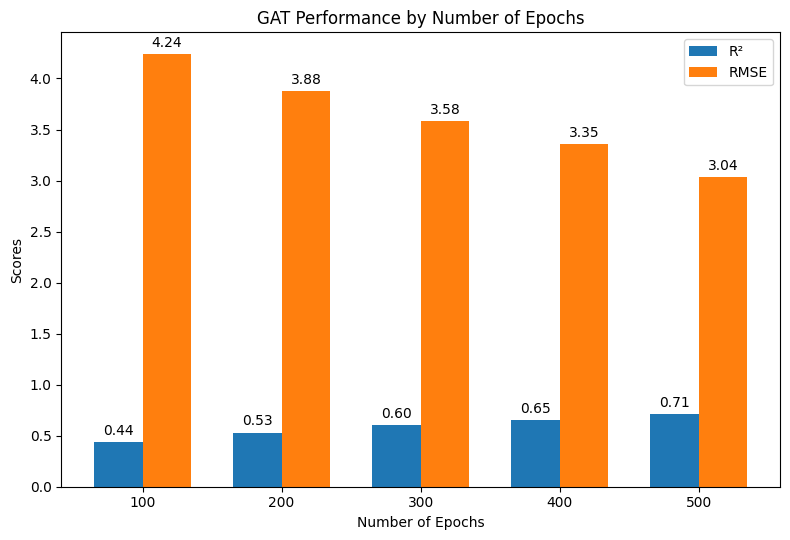

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_epoch.keys())
r2_scores = [v[0] for v in metrics_epoch.values()]
rmse_scores = [v[1] for v in metrics_epoch.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Scores')
ax.set_title('GAT Performance by Number of Epochs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Dropout Rates

In [29]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
metrics_dropouts = {}

for dr in dropout_rates:
    model_dr = GATModel(in_channels=num_node_features, hidden_dim=64, out_dim=1, dropout_rate=dr)
    train_gat_model(train_loader, model_dr, epochs=300, lr=1e-3)
    metrics_dropouts[dr] = r2_rmse(train_loader, model_dr)
metrics_dropouts

Epoch 1, Loss: 121.7965
Epoch 2, Loss: 142.4895
Epoch 3, Loss: 96.6432
Epoch 4, Loss: 134.2647
Epoch 5, Loss: 154.4000
Epoch 6, Loss: 118.2356
Epoch 7, Loss: 128.8964
Epoch 8, Loss: 113.2218
Epoch 9, Loss: 88.2019
Epoch 10, Loss: 84.1880
Epoch 11, Loss: 130.5329
Epoch 12, Loss: 110.9541
Epoch 13, Loss: 90.7598
Epoch 14, Loss: 94.6004
Epoch 15, Loss: 92.2286
Epoch 16, Loss: 119.7351
Epoch 17, Loss: 73.7839
Epoch 18, Loss: 77.9951
Epoch 19, Loss: 82.5324
Epoch 20, Loss: 115.5831
Epoch 21, Loss: 76.4983
Epoch 22, Loss: 87.5544
Epoch 23, Loss: 91.0196
Epoch 24, Loss: 87.3304
Epoch 25, Loss: 79.6051
Epoch 26, Loss: 76.4970
Epoch 27, Loss: 89.6081
Epoch 28, Loss: 97.6118
Epoch 29, Loss: 74.9331
Epoch 30, Loss: 91.7362
Epoch 31, Loss: 95.1201
Epoch 32, Loss: 76.5021
Epoch 33, Loss: 87.7827
Epoch 34, Loss: 88.4429
Epoch 35, Loss: 105.4245
Epoch 36, Loss: 85.8409
Epoch 37, Loss: 76.6111
Epoch 38, Loss: 82.2341
Epoch 39, Loss: 97.0496
Epoch 40, Loss: 79.0484
Epoch 41, Loss: 84.2725
Epoch 42, Los

{0.1: (0.6062047481536865, np.float64(3.5534727599062172)),
 0.2: (0.6409378051757812, np.float64(3.393146333344577)),
 0.3: (0.5741456747055054, np.float64(3.695288111664698)),
 0.4: (0.5710316896438599, np.float64(3.708773783269056)),
 0.5: (0.6005535125732422, np.float64(3.5788790645370434))}

In [30]:
for key, value in metrics_dropouts.items():
    print(f"Dropout Rate: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Dropout Rate: 0.1, R²: 0.606, RMSE: 3.553
Dropout Rate: 0.2, R²: 0.641, RMSE: 3.393
Dropout Rate: 0.3, R²: 0.574, RMSE: 3.695
Dropout Rate: 0.4, R²: 0.571, RMSE: 3.709
Dropout Rate: 0.5, R²: 0.601, RMSE: 3.579


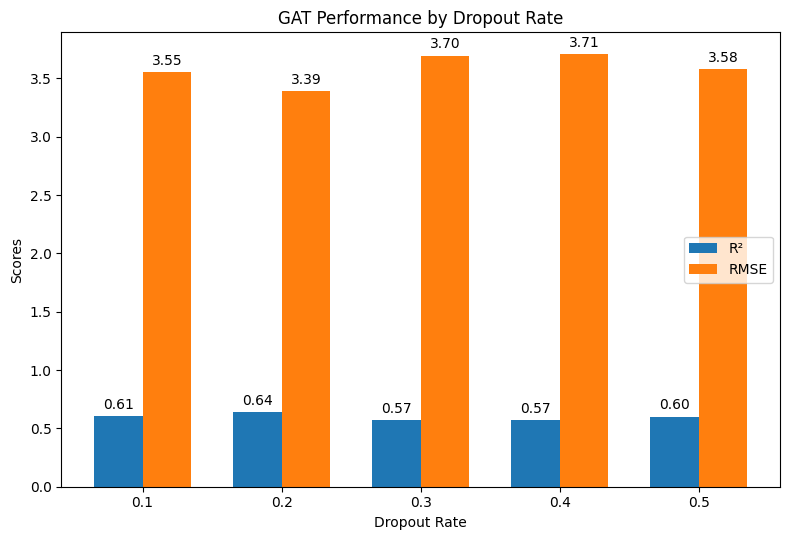

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_dropouts.keys())
r2_scores = [v[0] for v in metrics_dropouts.values()]
rmse_scores = [v[1] for v in metrics_dropouts.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Dropout Rate')
ax.set_ylabel('Scores')
ax.set_title('GAT Performance by Dropout Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


### Learning rate

In [32]:
lrs = [1e-1 ,1e-2 ,1e-3, 1e-4, 1e-5, 1e-6]
metrics_learnRate = {}

for lr in lrs:
    model_lr = GATModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gat_model(train_loader, model_lr, epochs=300, lr=lr)
    metrics_learnRate[lr] = r2_rmse(train_loader, model_lr)
    print(f"Learning Rate: {lr}, R²: {metrics_learnRate[lr][0]:.3f}, RMSE: {metrics_learnRate[lr][1]:.3f}")

Epoch 1, Loss: 123.5965
Epoch 2, Loss: 113.3428
Epoch 3, Loss: 92.4468
Epoch 4, Loss: 98.9867
Epoch 5, Loss: 77.7224
Epoch 6, Loss: 111.6949
Epoch 7, Loss: 75.0819
Epoch 8, Loss: 60.9036
Epoch 9, Loss: 92.9459
Epoch 10, Loss: 64.6243
Epoch 11, Loss: 61.4488
Epoch 12, Loss: 54.3523
Epoch 13, Loss: 79.4405
Epoch 14, Loss: 55.6864
Epoch 15, Loss: 130.4691
Epoch 16, Loss: 56.8953
Epoch 17, Loss: 60.7801
Epoch 18, Loss: 57.3923
Epoch 19, Loss: 56.1409
Epoch 20, Loss: 64.5358
Epoch 21, Loss: 61.7923
Epoch 22, Loss: 60.6995
Epoch 23, Loss: 95.6194
Epoch 24, Loss: 54.4615
Epoch 25, Loss: 60.0520
Epoch 26, Loss: 61.3360
Epoch 27, Loss: 50.8775
Epoch 28, Loss: 45.6085
Epoch 29, Loss: 44.4962
Epoch 30, Loss: 40.5907
Epoch 31, Loss: 83.7550
Epoch 32, Loss: 39.6931
Epoch 33, Loss: 44.3683
Epoch 34, Loss: 38.5632
Epoch 35, Loss: 50.6936
Epoch 36, Loss: 46.3777
Epoch 37, Loss: 45.7750
Epoch 38, Loss: 53.6922
Epoch 39, Loss: 37.8004
Epoch 40, Loss: 55.0753
Epoch 41, Loss: 43.8240
Epoch 42, Loss: 46.85

In [33]:
for key,value in metrics_learnRate.items():
    print(f"Learning Rate: {key}, R²: {value[0]:.3f}, RMSE: {value[1]:.3f}")

Learning Rate: 0.1, R²: 0.673, RMSE: 3.239
Learning Rate: 0.01, R²: 0.859, RMSE: 2.125
Learning Rate: 0.001, R²: 0.578, RMSE: 3.677
Learning Rate: 0.0001, R²: 0.113, RMSE: 5.334
Learning Rate: 1e-05, R²: -0.241, RMSE: 6.308
Learning Rate: 1e-06, R²: -0.251, RMSE: 6.333


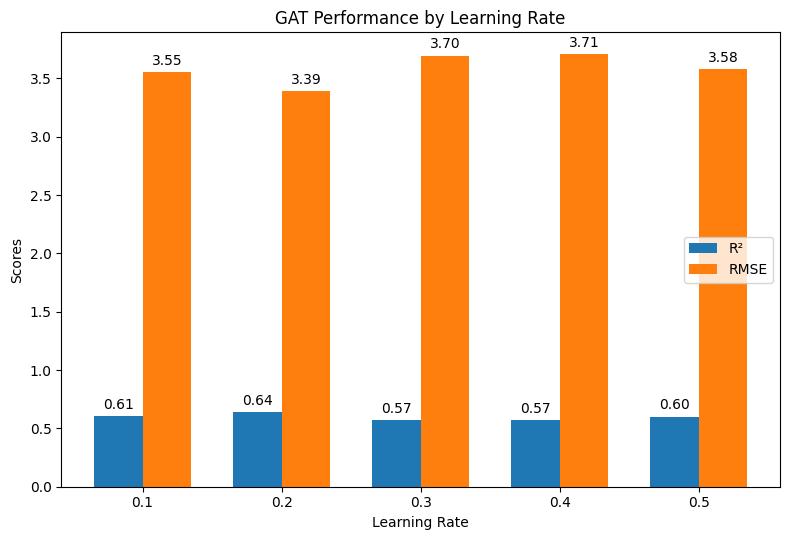

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_dropouts.keys())
r2_scores = [v[0] for v in metrics_dropouts.values()]
rmse_scores = [v[1] for v in metrics_dropouts.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Scores')
ax.set_title('GAT Performance by Learning Rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()


## Investigating the effect of Batch size on Training

In [35]:
batches = [1, 2, 4, 8, 16, 32, 64, 70]
metrics_batches = {}
for batch_size in batches:
    # train_loader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)
    model_b = GATModel(in_channels=num_node_features, hidden_dim=64, out_dim=1)
    train_gat_model(train_loader, model_b, lr=1e-3, epochs=300)
    metrics_batches[batch_size] = r2_rmse(train_loader, model_b)

Epoch 1, Loss: 92.2602
Epoch 2, Loss: 144.5353
Epoch 3, Loss: 109.8005
Epoch 4, Loss: 139.9007
Epoch 5, Loss: 103.0403
Epoch 6, Loss: 117.3556
Epoch 7, Loss: 92.5643
Epoch 8, Loss: 99.3827
Epoch 9, Loss: 143.7020
Epoch 10, Loss: 107.4440
Epoch 11, Loss: 104.2069
Epoch 12, Loss: 100.1351
Epoch 13, Loss: 117.7596
Epoch 14, Loss: 126.7954
Epoch 15, Loss: 76.5420
Epoch 16, Loss: 92.7510
Epoch 17, Loss: 126.7209
Epoch 18, Loss: 102.2391
Epoch 19, Loss: 76.8299
Epoch 20, Loss: 112.5595
Epoch 21, Loss: 103.2637
Epoch 22, Loss: 96.0575
Epoch 23, Loss: 106.2103
Epoch 24, Loss: 86.8784
Epoch 25, Loss: 92.1097
Epoch 26, Loss: 100.9999
Epoch 27, Loss: 72.5818
Epoch 28, Loss: 100.2785
Epoch 29, Loss: 90.1549
Epoch 30, Loss: 99.1474
Epoch 31, Loss: 76.4400
Epoch 32, Loss: 78.9051
Epoch 33, Loss: 90.6457
Epoch 34, Loss: 83.7121
Epoch 35, Loss: 76.3327
Epoch 36, Loss: 93.9011
Epoch 37, Loss: 72.5671
Epoch 38, Loss: 121.0516
Epoch 39, Loss: 79.7700
Epoch 40, Loss: 86.9837
Epoch 41, Loss: 102.9584
Epoch

In [36]:
metrics_batches

{1: (0.6236559152603149, np.float64(3.473843932472398)),
 2: (0.6075122952461243, np.float64(3.547568232476256)),
 4: (0.603590190410614, np.float64(3.5652494027105357)),
 8: (0.6502693295478821, np.float64(3.348764100481159)),
 16: (0.5974866151809692, np.float64(3.592591737599251)),
 32: (0.6100386381149292, np.float64(3.5361325428058445)),
 64: (0.619575023651123, np.float64(3.4926272804479717)),
 70: (0.6362699866294861, np.float64(3.4151302387653524))}

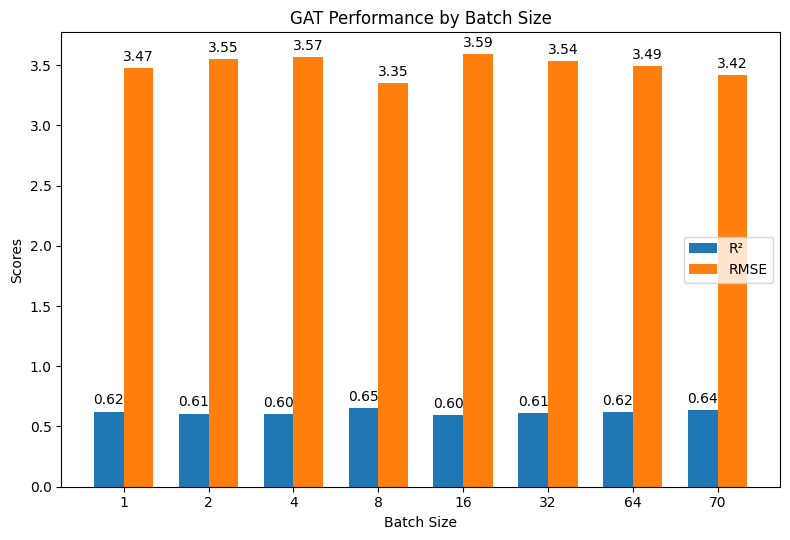

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Extract labels and scores
labels = list(metrics_batches.keys())
r2_scores = [v[0] for v in metrics_batches.values()]
rmse_scores = [v[1] for v in metrics_batches.values()]

# X positions for each group
x = np.arange(len(labels))

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5.5))

# Bars for R2
bars1 = ax.bar(x - width/2, r2_scores, width, label='R²')

# Bars for RMSE
bars2 = ax.bar(x + width/2, rmse_scores, width, label='RMSE')

# Labels and formatting
ax.set_xlabel('Batch Size')
ax.set_ylabel('Scores')
ax.set_title('GAT Performance by Batch Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Optionally add value labels on top
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()
